In [1]:
# Standard Imports
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

In [2]:
# Plotting
import matplotlib.pylab as plt
plt.rcParams['font.size'] = 14
import seaborn as sns
%matplotlib inline

C:\Users\Erin\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Performance
from time import time

In [4]:
# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
# Helper
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.grid_search import GridSearchCV

# Preliminaries

In [6]:
# Load in the Data
train = pd.read_csv('input/train3.csv')
test = pd.read_csv('input/test3.csv')

In [7]:
train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill,femalesHighClass,thirdClassFSingle,boysHighClass,singleMenFirstClass
0,1,0,3,1,0,1,0,22,7.2500,0,0,0,0
1,2,1,1,1,0,0,1,38,71.2833,1,0,0,0
2,3,1,3,0,0,0,0,26,7.9250,0,0,0,0
3,4,1,1,1,0,0,0,35,53.1000,1,0,0,0
4,5,0,3,0,0,1,0,35,8.0500,0,0,0,0


In [35]:
print("Survival rate is ", sum(train.Survived)/len(train.Survived))

Survival rate is  0.382452193476


# Feature engineering
See features generated in visualization and exploration notebook

# Hold-out set

In [8]:
# create hold-out set

features = list(train.columns.values)[2::]
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Survived'])

# Data exploration

In [9]:
X_train.groupby(y_train).mean()

,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill,femalesHighClass,thirdClassFSingle,boysHighClass,singleMenFirstClass
Survived,,,,,,,,,,,
0,2.536160,0.571072,0.34414,0.855362,0.321696,29.295511,22.635410,0.014963,0.017456,0.004988,0.012469
1,1.954717,0.464151,0.50566,0.305660,0.441509,27.400642,46.894576,0.494340,0.083019,0.045283,0.018868


In [10]:
X_train.groupby(X_train['Pclass']).mean()

,SibSp,Parch,Gender,Port,AgeFill,FareFill,femalesHighClass,thirdClassFSingle,boysHighClass,singleMenFirstClass
Pclass,,,,,,,,,,
1,0.462025,0.417722,0.537975,0.462025,37.300127,84.725765,0.462025,0.000000,0.025316,0.063291
2,0.387755,0.380952,0.564626,0.129252,28.998844,21.400652,0.435374,0.000000,0.068027,0.000000
3,0.614958,0.415512,0.709141,0.426593,24.521939,13.770901,0.000000,0.080332,0.000000,0.000000


# Data visualization 

## for more visualizations see 'Visualization and exploration' notebook

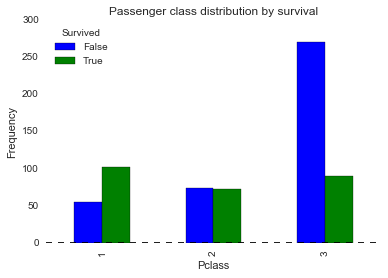

In [11]:
pd.crosstab(X_train.Pclass, y_train.astype(bool)).plot(kind='bar')
plt.title('Passenger class distribution by survival')
plt.xlabel('Pclass')
plt.ylabel('Frequency')

# Feature selection

In [16]:
# ch2 = SelectKBest(chi2, k = 7)
# X_train2 = ch2.fit_transform(X_train, y_train)
# X_train2[0:10]

array([[   2.    ,    0.    ,    0.    ,    0.    ,   26.    ,    0.    ,
           0.    ],
       [   1.    ,    0.    ,    0.    ,    1.    ,   27.7208,    0.    ,
           0.    ],
       [   1.    ,    0.    ,    1.    ,    0.    ,   26.55  ,    0.    ,
           0.    ],
       [   1.    ,    0.    ,    0.    ,    0.    ,  151.55  ,    0.    ,
           0.    ],
       [   3.    ,    0.    ,    1.    ,    0.    ,   18.    ,    0.    ,
           0.    ],
       [   3.    ,    0.    ,    1.    ,    0.    ,    8.6625,    0.    ,
           0.    ],
       [   2.    ,    1.    ,    0.    ,    0.    ,   26.    ,    0.    ,
           1.    ],
       [   1.    ,    0.    ,    1.    ,    0.    ,   26.55  ,    0.    ,
           0.    ],
       [   3.    ,    0.    ,    0.    ,    2.    ,   15.5   ,    0.    ,
           0.    ],
       [   3.    ,    0.    ,    0.    ,    0.    ,    7.925 ,    0.    ,
           0.    ]])

In [12]:
# predictors = list(X_train.columns.values[ch2.get_support()])
predictors = list(X_train.columns.values)
print(predictors)

['Pclass', 'SibSp', 'Parch', 'Gender', 'Port', 'AgeFill', 'FareFill', 'femalesHighClass', 'thirdClassFSingle', 'boysHighClass', 'singleMenFirstClass']


# Find random forest hyperparameters
**Goal**: select best number of estimators for random forest

In [13]:
def searchHyperparameters(X, y, param_grid, alg, cval = 10, score = 'accuracy'):
    
    # instantiate the grid
    grid = GridSearchCV(alg, param_grid, cv = cval, scoring = score)
    
    # fit the grid with data
    grid.fit(X, y)
    
    # view the complete results
    print("Best score:", grid.best_score_)
    print("Best parameters:", grid.best_params_)
    print("Best model:", grid.best_estimator_)
    
    # note if SD high, cross-val estimates may not be reliable
    results = grid.grid_scores_
    return results, grid

In [14]:
# Initialize our algorithm
alg = RandomForestClassifier()

In [15]:
# define parameter values to be searched
tree_range = [1, 50, 100, 150, 200]
crit_range = ['gini', 'entropy']
param_grid = dict(n_estimators = tree_range, criterion = crit_range)
print(param_grid)

{'n_estimators': [1, 50, 100, 150, 200], 'criterion': ['gini', 'entropy']}


In [16]:
start = time()
res, grid = searchHyperparameters(X_train[predictors], y_train, param_grid, alg, 5, 'roc_auc')
print("\nTime elapsed (s) is:", time() - start)

Best score: 0.864970036424
Best parameters: {'n_estimators': 200, 'criterion': 'entropy'}
Best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Time elapsed (s) is: 6.605672836303711


In [17]:
[print(val) for val in res]

mean: 0.75384, std: 0.05880, params: {'n_estimators': 1, 'criterion': 'gini'}
mean: 0.85665, std: 0.04097, params: {'n_estimators': 50, 'criterion': 'gini'}
mean: 0.86050, std: 0.03837, params: {'n_estimators': 100, 'criterion': 'gini'}
mean: 0.86368, std: 0.03687, params: {'n_estimators': 150, 'criterion': 'gini'}
mean: 0.86050, std: 0.03579, params: {'n_estimators': 200, 'criterion': 'gini'}
mean: 0.75837, std: 0.04771, params: {'n_estimators': 1, 'criterion': 'entropy'}
mean: 0.86325, std: 0.03736, params: {'n_estimators': 50, 'criterion': 'entropy'}
mean: 0.86405, std: 0.03782, params: {'n_estimators': 100, 'criterion': 'entropy'}
mean: 0.86373, std: 0.03668, params: {'n_estimators': 150, 'criterion': 'entropy'}
mean: 0.86497, std: 0.03701, params: {'n_estimators': 200, 'criterion': 'entropy'}


[None, None, None, None, None, None, None, None, None, None]

In [18]:
# Predict class for hold-out set.
holdout_pred = grid.predict(X_test[predictors])

# Model evaluation

In [19]:
def evaluation_metrics(ytest, ypred):
    
    # null accuracy
    null_accuracy = round(ytest.value_counts().max()/len(ytest), 3)
    print("Null accuracy:", null_accuracy)

    accuracy = round(accuracy_score(ytest, ypred), 3)
    print("Accuracy:", accuracy)
    
    confusion = confusion_matrix(ytest, ypred)
    print("Confusion matrix: actual(0,1) x predicted(0,1)\n", confusion)
    
    sensitivity = round(recall_score(ytest, ypred), 3)
    print("Sensitivity: when actual is positive, how often predicted positive", sensitivity)
    
    specificity = round(confusion[0,0]/(confusion[0,0] + confusion[0,1]), 3)
    print("Specificity: when actual is zero, how often predicted zero", specificity)

    precision = round(precision_score(ytest, ypred), 3)
    print("Precision: when predicted is positive, how often actual positive", precision)
    
    return accuracy, confusion, sensitivity, specificity, precision

In [20]:
def evaluate_prob(ytest, pred_prob):
    
    # histogram of probabilities
    plt.subplot(1, 2, 1)
    plt.hist(pred_prob, bins = 8)
    plt.xlim(0, 1)
    plt.title('Histogram of pred probabilities')
    plt.xlabel('Predicted probability of positive')
    plt.ylabel('Frequency')
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(ytest, pred_prob)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("ROC curve")
    plt.xlabel("False positive rate (1 - specificity)")
    plt.ylabel("True positive rate (sensitivity)")
    plt.grid(True)
    
    plt.tight_layout() # adds more space between plots
    
    auc = round(roc_auc_score(y_test, predict_prob), 3)
    print("AUC score is:", auc)
    
    return fpr, tpr, thresholds, auc

In [21]:
# Use ROC curve to determine sensitivity & specificity for a given threshold
def evaluate_threshold(threshold):
    print("Sensitivity:", tpr[thresholds > threshold][-1])
    print("Specificity:", 1-fpr[thresholds > threshold][-1])

In [22]:
# Retrieve evaluation metrics
acc, conf, sens, spec, prec = evaluation_metrics(y_test, holdout_pred)

Null accuracy: 0.664
Accuracy: 0.798
Confusion matrix: actual(0,1) x predicted(0,1)
 [[130  18]
 [ 27  48]]
Sensitivity: when actual is positive, how often predicted positive 0.64
Specificity: when actual is zero, how often predicted zero 0.878
Precision: when predicted is positive, how often actual positive 0.727


In [23]:
# Predict probabilities for hold-out set
predict_prob = grid.predict_proba(X_test[predictors])[:,1]

AUC score is: 0.825


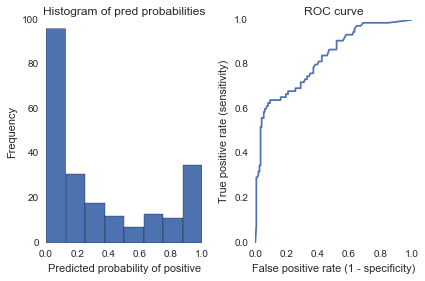

In [24]:
# Retrieve probability metrics
fpr, tpr, thresholds, auc = evaluate_prob(y_test, predict_prob)

In [25]:
# Determine class metrics for new threshold
evaluate_threshold(0.5)

Sensitivity: 0.64
Specificity: 0.878378378378


In [26]:
# Determine class metrics for new threshold
evaluate_threshold(0.25)

Sensitivity: 0.693333333333
Specificity: 0.709459459459


In [27]:
# Change threshold for classification 
# One of the last steps in the model building process
from sklearn.preprocessing import binarize
y_pred_thresh = binarize(predict_prob, 0.3)[0]

C:\Users\Erin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [28]:
acc, conf, sens, spec, prec = evaluation_metrics(y_test, y_pred_thresh)

Null accuracy: 0.664
Accuracy: 0.74
Confusion matrix: actual(0,1) x predicted(0,1)
 [[114  34]
 [ 24  51]]
Sensitivity: when actual is positive, how often predicted positive 0.68
Specificity: when actual is zero, how often predicted zero 0.77
Precision: when predicted is positive, how often actual positive 0.6


# Final step - submission

In [29]:
# Make predictions for test set.
test_pred = grid.predict(test[predictors])

In [30]:
test_predprob = grid.predict_proba(test[predictors])

In [31]:
test_predprob[10:20][:,1]

array([ 0.    ,  0.0525,  1.    ,  0.105 ,  0.985 ,  0.985 ,  0.126 ,
        0.67  ,  0.44  ,  0.22  ])

In [32]:
test_pred[0:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [33]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": test_pred
    })

# Any files you save will be available in the output tab below
submission.to_csv('submission.csv', index=False)